# Case 3. Probably Scores (Python) <img src='images/rsm-mgta403-probably-scores.png' align="right" height="138.5" />

Sports analytics has become a popular application of statistics. Driven by large amounts of data and revenue generated by sports, many analysts have leveraged data to help teams make important decisions. In this exercise, we will use data and probability to predict the winner of a soccer game. More specifically, we will produce real-time predictions for a penalty shoot-out just like those generated by the analytics website <a href="https://fivethirtyeight.com/features/a-chart-for-predicting-penalty-shootout-odds-in-real-time/" target="_blank">FiveThirtyEight</a>.

For this exercise, you do not need to know anything about sports. Instead, we will focus on conducting exploratory data analysis, applying probability rules, and producing figures to present your analysis.

<div align="center">
  <img src='https://imgs.xkcd.com/comics/sports.png' />
</div>

## For local analysis
To complete all exercises below, you will also need two data files, <a href="data/shootouts.csv">shootouts.csv</a> and <a href="data/takers.csv">takers.csv</a>

## Context

In a soccer tournament when the teams have an equal number of goals after 120 minutes, the winner is decided by a penalty shoot-out. In a penalty shoot-out, each team designates players to shoot the ball at the goal, which is defended by a goalkeeper. This is called a "penalty kick." Each teams gets five opportunities to score. The team that scores the most penalty kicks in those five turns wins. If the teams score an equal number of penalty kicks after five rounds the shootout becomes "sudden death." Each team will take one more additional penalty kick. In each one of these additional rounds, if one team scores and one team misses, the game is over and the team who made the final penalty kick wins. If both teams miss or both teams score, then the teams proceed to another round of sudden death.

In order to check your understanding of the context, answer the following quiz question.


In [22]:
# Question 3.01: What is the fewest number of rounds possible in a penalty-shootout? Note that a penalty shoot-out will end before five kicks have been taken by each team if one team would win regardless of the outcome of subsequent kicks.

3

3

Before we get started, let's consider the main goal (no pun intended) of this exercise. Using data, we want to produce a predicted probability for a given team to win at each point in the penalty shoot-out.


In [24]:
# Question 3.02: Think about what data you would need to calculate this prediction. Also, sketch out some ideas about how you could calculate the probability at each point in the penalty shoot-out. There is no wrong or right answer at this point. Any answer will be accepted.


# Historical probability data of kicker( no of successful kicks per 100)
# Historical probability data of goalkeeper( no of saves per 100)
# The probability of the kicker scoring at a particular round in a shootout.
# Probability of the kicker scoring when he is facing a particular keeper, Probability of the goalkeeper saving a shot when facing a particular kicker.

## Data

Let's get started by loading data related to penalty shoot-outs. 


In [25]:
# Question 3.03: Using the function `read_csv` from the Pandas library, load
# the file `shootouts.csv` into a `DataFrame` called `shootouts`. Load the
# dataset `takers.csv` into a `DataFrame` called `takers`. Note that these
# datasets are located in the directory `data_mgta403/`.

import pandas as pd
import numpy as np

shootouts = pd.read_csv("shootouts.csv") # Replace with your code
takers = pd.read_csv("takers.csv")  # Replace with your code

takers.head(15) # should show the first 6 rows of the dataset  # should show the first 6 rows of the dataset


,taker_pos,taker_name,taker_result,taker_href,taker_outcome,taker_team,game_id
0,1,Alain Giresse,First penalty,https://en.wikipedia.org/wiki/Alain_Giresse,scored,loser,1
1,1,Manfred Kaltz,NaN,https://en.wikipedia.org/wiki/Manfred_Kaltz,scored,winner,1
2,2,Manuel Amoros,NaN,https://en.wikipedia.org/wiki/Manuel_Amoros,scored,loser,1
3,2,Paul Breitner,NaN,https://en.wikipedia.org/wiki/Paul_Breitner,scored,winner,1
4,3,Dominique Rocheteau,NaN,https://en.wikipedia.org/wiki/Dominique_Rocheteau,scored,loser,1
5,3,Uli Stielike,NaN,https://en.wikipedia.org/wiki/Uli_Stielike,missed,winner,1
6,4,Didier Six,NaN,https://en.wikipedia.org/wiki/Didier_Six,missed,loser,1
7,4,Pierre Littbarski,NaN,https://en.wikipedia.org/wiki/Pierre_Littbarski,scored,winner,1
8,5,Michel Platini,NaN,https://en.wikipedia.org/wiki/Michel_Platini,scored,loser,1
9,5,Karl-Heinz Rummenigge,NaN,https://en.wikipedia.org/wiki/Karl-Heinz_Rumme...,scored,winner,1


### Exploring the data

Before getting into the prediction exercise, let's do a bit of exploratory data analysis (EDA) to get familiar with the dataset we're using.


In [26]:
# Question 3.04: How many shootouts have taken place in the men's World Cup?
# Store your answer in a variable called `number_of_shootouts`. How many
# penalty kicks have been taken in the men's World Cup? Store your answer in a
# variable called `number_of_takers`. If you are unsure how to find the number
# of rows in a `DataFrame`, click the 'Hint' button.

number_of_shootouts = shootouts['game_id'].nunique() # Replace with your code
number_of_takers = len(takers['taker_pos'])  # Replace with your code

print(number_of_shootouts)
print(number_of_takers)

30
279


In [30]:
# Question 3.05: Create a function `table` that takes a list or vector as input
# and returns a Pandas DataFrame with 1 column that contains the counts for
# each unique entry. the DataFrame index should show the unique entries that
# correspond to the calculated counts. Use Numpy to generate the required
# counts

import numpy as np
import pandas as pd

def table(x):
    keys_ = list(set(x))
    dict_ = {key : x.count(key)  for key in keys_}
    df = pd.DataFrame(dict_.values(), index=dict_.keys(), columns=["nr"])
    return df


print(table(["a", "b", "b"]).loc["b", "nr"]) # should return 2
print(table([1, 2, 3, 2]).loc[1, "nr"]) # should return 1

2
1


In [32]:
# Question 3.06: Adapt your `table` function with an additional argument
# (`ascending`) to sort the DataFrame if needed. `ascending=None` should leave
# the DataFrame as is. `ascending=True` should sort the DataFrame in ascending
# order and `ascending=False` should sort the DataFrame in descending order

import numpy as np

def table(x, ascending=None):
    counts = np.unique(x, return_counts=True)
    df = pd.DataFrame(counts[1], index=counts[0], columns=["nr"])
    if(ascending is None):
        return df
    else:
         df = df.sort_values(by=['nr'], ascending=ascending)
         return df

  
print(table(["a", "b", "b"]).iloc[0][0]) # should return 1
print(table(["a", "b", "b"], ascending=False).iloc[0][0]) # should return 2
print(table([1, 2, 3, 2], ascending=True).iloc[-1][0]) # should return 2

1
2
2


Now you are equipped with the functions you need to help you with the next exercise where we will start to analyze the data.


In [33]:
# Question 3.07: Use your `table` function from the previous question to
# determine which country has won the most penalty shootouts. Store the name of
# that country in a variable called `most_wins`. Use the `table` function again
# to determine which country has lost the most penalty shootouts. Store the
# name of that country in a variable called `most_losses`. Note that you should
# treat 'Germany' and 'West Germany' as two different countries. If there are
# ties for the most wins or losses, just report one of the countries.

most_wins = table(shootouts['winner'],ascending = False).index[0] # Replace with your code
most_losses = table(shootouts['loser'],ascending = False).index[0]  # Replace with your code

# Should return just one country name
print(most_wins)

# Should return just one country name. If there are ties, just pick any one of them
print(most_losses)

Argentina
Italy


In [34]:
wins_ = table(shootouts['winner'])
losses_ = table(shootouts['loser'])
most_shootouts =   wins_.add(losses_, fill_value=0)
most_shootouts = most_shootouts.sort_values(by=['nr'], ascending=False).index[0]

print(most_shootouts)

Argentina


Now let's focus on the most important statistic for our predictions. We need to estimate the probability that a penalty will be scored. We could do this by simply looking at the fraction of penalties that have been scored.


In [35]:
# Question 3.09: Use the `takers` DataFrame to calculate the probability of a
# successful penalty kick being scored. Store this number in a variable called
# `p_score`.

p_score =  len(takers[takers['taker_outcome'] == 'scored'])/takers['taker_outcome'].count()
print(p_score)

0.7025089605734767


In [38]:
# Question 3.10: Explain why <a href='https://fivethirtyeight.com/features/a-chart-for-predicting-penalty-shootout-odds-in-real-time/' target='_blank'>FiveThirtyEight</a> revises their estimate of the 'long-run' probability of scoring from 71.5 percent to 72.5 percent.

# The World Cup doesn't happen frequently, and penalty shootouts are relatively rare events even within the tournament.
# This means that the sample size for World Cup penalty kicks might not be large enough to provide a robust estimate. 
# A small sample size can lead to more variability in the estimated probability, making it sensitive to the specific data points in the sample.

## Real-time shootout predictions

Now let's get to work on recreating the predictions from <a href="https://fivethirtyeight.com/features/a-chart-for-predicting-penalty-shootout-odds-in-real-time/" target="_blank">FiveThirtyEight</a>. 

### Sudden death

Let's begin by first considering the "Sudden Death" stage of the game where during each round both teams take a single penalty kick. If one team scores and the other team misses, the team that scored wins. If both teams score or both teams miss, they advance to another round of sudden death.

For simplicity, denote the team that goes first as Team A and the team that goes second as Team B. We'll denote the probability of team A scoring as $p_{A}$ and the probability of team B scoring as $p_{B}$. For now, let's assume that each penalty kick taker for both teams has the same probability of scoring equal to 0.725. That is, $p_A = p_B = 0.725$.

Check your understanding of the probability of winning sudden death with the quiz questions below.


In [39]:
# Question 3.11: At the beginning of sudden death, what is the probability that Team A wins? You can use your intuition to answer this. Remember that probabilities range between 0 and 1.

0.5 

#Because at the start both teams have equal probability of winning

0.5

In [40]:
# Question 3.12: In sudden death, if Team A misses its first kick, what is the probability that Team A wins?

0.1375

#(1-P_b)*(0.5) - B has to miss and sudden death starts again

In [42]:
# Question 3.13: In sudden death, if Team A scores their kick, what is the probability that Team A wins?

0.6375

#(1-P_b) + (P_a)*(1-P_b)

0.6375

Now let's create a function that returns the probabilities of Team A winning. We will again start with the simpler situation in which the teams have entered sudden death.


In [43]:
# Question 3.14: Write a function called `sudden_prob_a_win` that accepts the
# current scoreline and the turn of the team taking the penalty ('A' if its
# Team A's turn and 'B' if its Team B's turn). Your function should return the
# probability that Team A wins for the relevant situation.

def sudden_prob_a_win(scored_a, scored_b, turn):
    p_a = p_b = 0.725
    w_a = 0.5
    
    if(scored_a == scored_b and turn == "A"):
        return w_a
    elif(scored_a == scored_b and turn == "B"):
        return (1-p_b) * w_a
    elif(scored_a > scored_b and turn == "B"):
        return ((1-p_b) + (p_b*w_a))
        
 

sudden_prob_a_win(3, 3, "A") # Should return the answer to Question 11
sudden_prob_a_win(3, 3, "B") # Should return the answer to Question 12
sudden_prob_a_win(4, 3, "B") # Should return the answer to Question 13

0.6375

Now let's consider what happens in the first stage of the penalty shootout in which the team that scores the most penalty kicks out of five kicks wins. Before we begin, let's work through a probability calculation.


In [44]:
# Question 3.15: If each team takes four penalty kicks, what is the probability that Team A scores 4 and Team B scores 3? Assume that the probability of scoring is independent between kicks. If you are unsure, feel free to click 'Hint'. Report your answer with 4 decimal places

# (P_a ** 4)(4c3 * (P_b ** 3) *(1-P_b))

We want to calculate the probability that Team A wins at each point in the penalty shoot-out. Before we begin, let's consider all possible scores in the first five rounds that result (or could result) in Team A winning before either team takes any penalty kick. You *should* include scores such as 5-1.


In [45]:
# Question 3.16: Create a `DataFrame` containing all possible scores in five
# rounds and then restrict the `DataFrame` to the scores that result in Team A
# NOT losing. Assign this `DataFrame` the name `scores_in5`. The column
# containing Team A's score should be called `score_a` and the column
# containing Team B's score should be called `score_b`. Make sure you include
# ties from the first five rounds. Also, include scores such as 5-1.

import pandas as pd

possible_scores = [] # Replace with your code

for i in range(6):
    for j in range(6):
        if j<=i:
            possible_scores.append((i,j))
            
scores_in5 = pd.DataFrame(possible_scores, columns=["score_a","score_b"])            

# using the product function from itertools
from itertools import product

scores_in5.columns # Should return ["score_a" "score_b"]
scores_in5.shape # Should return (21, 2)

scores_in5

,score_a,score_b
0,0,0
1,1,0
2,1,1
3,2,0
4,2,1
5,2,2
6,3,0
7,3,1
8,3,2
9,3,3


In [47]:
# Question 3.17: Add a new column to `scores_in5` called `p_score` which
# contains the probability of each scoreline from the beginning of the game
# (i.e., before either team takes a penalty kicks). When you calculate the
# probabilities, assume each team gets to take five kicks regardless of their
# outcomes (i.e., 5-1 has a positive probability).

from scipy.stats import binom

 # Replace with your code
list_scores = []
i=0
for i in range(len(scores_in5)):
    list_scores.append(binom.pmf(scores_in5.loc[i, 'score_a'], n=5, p=0.725) * binom.pmf(scores_in5.loc[i, 'score_b'], n=5, p=0.725))
    i = i + 1
    
scores_in5["p_score"] = list_scores
    

scores_in5.head()

,score_a,score_b,p_score
0,0,0,0.000002
1,1,0,0.000033
2,1,1,0.000430
3,2,0,0.000172
4,2,1,0.002266


<div class="resources">
Before you dive into the next questions, take a look at the following documentation.
  <ul>
    <li><a href="https://numpy.org/doc/1.20/reference/generated/numpy.where.html" target="_blank">np.where</a></li>
    <li><a href="https://numpy.org/doc/1.20/reference/generated/numpy.isin.html" target="_blank">np.isin</a></li>
  </ul>
</div>



In [48]:
# Question 3.18: Now let's take these probabilities and convert them into the
# probability of Team A winning. Create a new column called `p_win`. If Team A
# has more goals than Team B in 5 turns, then assign `p_win` the value in
# `p_score`. If they have the same number of goals, then assign `p_win` the
# value in `p_score` times the probability of Team A winning in sudden death.
# Use the `where` function in Numpy.

import numpy as np

scores_in5["p_win"] =  np.where(scores_in5["score_a"] > scores_in5["score_b"],scores_in5["p_score"],(scores_in5["p_score"]*0.5) )

# This should equal the probability of Team A winning
# before either team takes a kick.
scores_in5.p_win.sum()  # should return a float

0.4999999999999994

So we were able to calculate the probability that Team A wins before either team takes a kick. Now let's consider the probability that Team A wins given that they score their first kick.


In [49]:
# Question 3.19: Assume Team A goes first and scores their first kick. Create a
# new DataFrame with the possible scores in the first five rounds (given that
# Team A has scored their first kick). Call this DataFrame `to_win`. Create a
# new column for Team A with the number of additional goals Team A needs to
# reach the number of goals in the column `score_a`. Call this column `add_a`.
# Do the same for Team B. Now calculate the probability of those additional
# goals being scored. Remember Team A now has four remaining penalties.
# Finally, create a column called `p_win` in a similar way that you did for the
# previous question.

from scipy.stats import binom

possible_scores = [] # Replace with your code

for i in range(1,6):
    for j in range(6):
        if j<=i:
            possible_scores.append((i,j))
            
to_win = pd.DataFrame(possible_scores, columns=["score_a","score_b"])    
to_win["add_a"] = to_win["score_a"] - 1
to_win["add_b"] = to_win["score_b"]
list_scores = []
for i in range(len(to_win)):
    list_scores.append(binom.pmf(to_win.loc[i, 'add_a'], n=4, p=0.725) * binom.pmf(to_win.loc[i, 'add_b'], n=5, p=0.725))
    i = i + 1
print(len(list_scores))
to_win["p_score"] = list_scores

to_win["p_win"] =  np.where(to_win["score_a"] > to_win["score_b"],to_win["p_score"],(to_win["p_score"]*0.5) )
print(to_win)



# Check that the probability of Team A winning approximately matches 
# the appropriate cell from FiveThirtyEight's blog post (first figure)
to_win.p_win.sum()

20
    score_a  score_b  add_a  add_b   p_score     p_win
0         1        0      0      0  0.000009  0.000009
1         1        1      0      1  0.000119  0.000059
2         2        0      1      0  0.000095  0.000095
3         2        1      1      1  0.001250  0.001250
4         2        2      1      2  0.006593  0.003296
5         3        0      2      0  0.000375  0.000375
6         3        1      2      1  0.004945  0.004945
7         3        2      2      2  0.026072  0.026072
8         3        3      2      3  0.068734  0.034367
9         4        0      3      0  0.000659  0.000659
10        4        1      3      1  0.008691  0.008691
11        4        2      3      2  0.045823  0.045823
12        4        3      3      3  0.120805  0.120805
13        4        4      3      4  0.159243  0.079622
14        5        0      4      0  0.000435  0.000435
15        5        1      4      1  0.005728  0.005728
16        5        2      4      2  0.030201  0.030201
17     

0.5746791807644537

Finally, this last question asks you to apply everything from the previous questions to create a function that calculates the probability of Team A winning for *any* given round, score and turn. For example, you want to be able to calculate the probability of Team A winning given it's the 3rd round, Team A has scored 2 goals, Team B has scored 2 goals and it's Team B's turn to take a penalty kick.


In [50]:
# Question 3.20: Create a function that returns the probability of Team A
# winning that accepts `round` (short for the current round), `curr_a` (short
# for the number of penalty kicks that Team A has won), `curr_b` (short for the
# number of penalty kicks that Team B has won) and `turn` (short for whose turn
# it is which is either Team 'A' or Team 'B'). Look at the end of the code
# template below to see how the function should be used.

def prob_win_a(round, curr_a, curr_b, turn):
    p_a = p_b = 0.725
    w_a = 0.5
    if (round > 5):
        if(curr_a == curr_a and turn == "A"):
            return w_a
        elif(curr_a == curr_a and turn == "B"):
            return (1-p_b) * w_a
        elif(curr_a > curr_a and turn == "B"):
            return ((1-p_b) + (p_b*w_a))
    else:
        return calculate_probability(round,curr_a,curr_b, turn)
        
def calculate_probability(round,curr_a,curr_b, turn):
    penalty_possible_scores = [] # Replace with your code
    Low_range_i = curr_a
    range_of_B_remain = 6-round
    if turn == "A":
        Upper_range_i = curr_a + (6-round) + 1
        range_of_A_remain = (6-round)
    else:
        Upper_range_i = curr_a + (6-round)
        range_of_A_remain = (6-round-1)

    for i in range(Low_range_i,Upper_range_i):
        for j in range(curr_b,6):
            if j<=i:
                penalty_possible_scores.append((i,j))
        
    df_scores = pd.DataFrame(penalty_possible_scores, columns=["score_a","score_b"])
    df_scores["add_a"] = df_scores["score_a"] - curr_a
    df_scores["add_b"] = df_scores["score_b"] - curr_b
    list_scores = []
    i=0
    for i in range(len(df_scores)):
        list_scores.append(binom.pmf(df_scores.loc[i, 'add_a'], n=range_of_A_remain, p=0.725) * binom.pmf(df_scores.loc[i, 'add_b'], n=range_of_B_remain, p=0.725))
        i = i + 1
    df_scores["p_score"] = list_scores
    
    df_scores["p_win"] =  np.where(df_scores["score_a"] > df_scores["score_b"],df_scores["p_score"],(df_scores["p_score"]*0.5) )
    return np.round(df_scores.p_win.sum(), 7)

print(prob_win_a(1, 0, 0, "A")) # Should return 0.5
print(prob_win_a(1, 1, 0, "B")) # Should return 0.5746792
print(prob_win_a(6, 4, 4, "A")) # Should return 0.5
print(prob_win_a(6, 4, 4, "B")) # Should return 0.1375

0.5
0.5746792
0.5
0.1375


## Presenting your results

Now let's work on providing the real-time predictions in graphical form for readers of FiveThirtyEight. During a game, FiveThirtyEight present a <a href="https://en.wikipedia.org/wiki/Area_chart" target="_blank">stacked area graph</a> live during the game. For example, check out their predictions during <a href="https://projects.fivethirtyeight.com/2018-world-cup-predictions/matches/" target="_blank">the 2018 World Cup</a>. For this exercise, we'll investigate the predicted probability of victory in the Italy versus Brazil penalty shoot-out in 1994. We'll examine actual round-by-round outcomes from this game, which you previously stored in a `DataFrame` called `takers`.

Before you dive into the next questions, you may find the following documentation helpful. Experiment with each of these functions to make sure you understand how they work.
<div class="resources">
  <ul>
    <li><a href="https://numpy.org/doc/1.20/reference/generated/numpy.cumsum.html" target="_blank">cumsum</a></li>
    <li><a href="https://www.freecodecamp.org/news/the-python-modulo-operator-what-does-the-symbol-mean-in-python-solved/" target="_blank">%</a></li>
  </ul>
</div>


In [51]:
# Question 3.21: Store the `game_id` of the Brazil versus Italy shootout in
# 1994 in a variable called `bra_ita_game_id`. You can select this `game_id` by
# using the year and name of the winner (which was Brazil) in the `DataFrame`
# called `shootouts` that you loaded earlier. Then take a subset of the penalty
# takers from this game in the `DataFrame` called `takers` using the `game_id`
# stored in `bra_ita_game_id`. Store this subset in a DataFrame called
# `bra_ita_takers`.

bra_ita = (shootouts.year == 1994) & (shootouts.winner == "Brazil")
bra_ita_game_id = shootouts.loc[bra_ita, "game_id"]
bra_ita_takers = takers[np.isin(takers.game_id, bra_ita_game_id)].reset_index(drop=True).copy()

type(bra_ita)
print(bra_ita_game_id)
print(bra_ita_takers)

10    11
Name: game_id, dtype: int64
   taker_pos                             taker_name   taker_result  \
0          1                          Franco Baresi  First penalty   
1          1  Márcio Santos (footballer, born 1969)            NaN   
2          2                     Demetrio Albertini            NaN   
3          2                                Romário            NaN   
4          3                         Alberigo Evani            NaN   
5          3                    Branco (footballer)            NaN   
6          4                        Daniele Massaro            NaN   
7          4                                  Dunga            NaN   
8          5                         Roberto Baggio    Ending miss   

                                          taker_href taker_outcome taker_team  \
0        https://en.wikipedia.org/wiki/Franco_Baresi        missed      loser   
1  https://en.wikipedia.org/wiki/M%C3%A1rcio_Sant...        missed     winner   
2   https://en.wiki

In [52]:
# Question 3.22: Add the probability of Italy winning the penalty shootout to
# each row of the DataFrame `bra_ita_takers` into a new column called
# `p_win_a`. The probability of Italy winning on each row should correspond to
# the probability after the event of that row happens. For example, in the
# first row, Italy misses the first kick. So, the first row should have the
# probability of Italy winning given Italy missed the first kick.

def calculate_probabilities():
    curr_A = 0
    curr_B = 0
    probabilities = []
    for i in range(len(bra_ita_takers)):
        if bra_ita_takers['taker_team'][i] == 'loser':
            if bra_ita_takers['taker_outcome'][i] == 'scored':
                curr_A = curr_A + 1
        if bra_ita_takers['taker_team'][i] == 'winner':
            if bra_ita_takers['taker_outcome'][i] == 'scored':
                curr_B = curr_B + 1
        if bra_ita_takers['taker_team'][i] == 'loser':
            if((i+1)%2 == 0):
                bra_ita_takers['taker_pos'][i] = bra_ita_takers['taker_pos'][i] + 1
            probabilities.append(prob_win_a(bra_ita_takers['taker_pos'][i],curr_A,curr_B,'B'))
            print((bra_ita_takers['taker_pos'][i],curr_A,curr_B,'B'))
        if bra_ita_takers['taker_team'][i] == 'winner':
            if((i+1)%2 == 0):
                bra_ita_takers['taker_pos'][i] = bra_ita_takers['taker_pos'][i] + 1
            probabilities.append(prob_win_a(bra_ita_takers['taker_pos'][i],curr_A,curr_B,'A'))
            print((bra_ita_takers['taker_pos'][i],curr_A,curr_B,'A'))
    return probabilities
    
bra_ita_takers["p_win_a"] = calculate_probabilities() # Replace with your code

bra_ita_takers.loc[0, "p_win_a"]# Should be 0.3031185

(1, 0, 0, 'B')
(2, 0, 0, 'A')
(2, 1, 0, 'B')
(3, 1, 1, 'A')
(3, 2, 1, 'B')
(4, 2, 2, 'A')
(4, 2, 2, 'B')
(5, 2, 3, 'A')
(5, 2, 3, 'B')


/tmp/ipykernel_16971/868053403.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bra_ita_takers['taker_pos'][i] = bra_ita_takers['taker_pos'][i] + 1
/tmp/ipykernel_16971/868053403.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bra_ita_takers['taker_pos'][i] = bra_ita_takers['taker_pos'][i] + 1
/tmp/ipykernel_16971/868053403.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bra_ita_takers['taker_pos'][i] = bra_ita_takers['ta

0.3031185

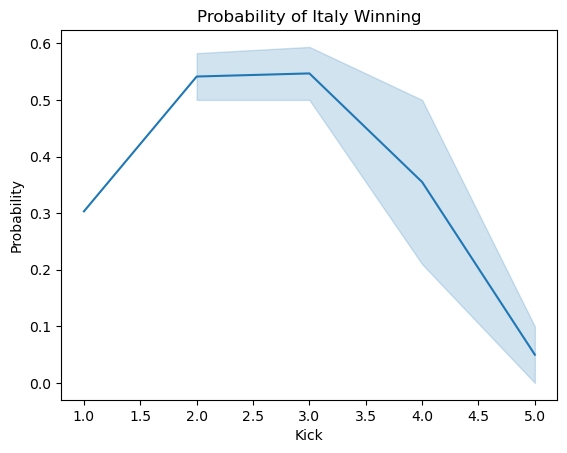

In [53]:
# Question 3.23: Finally, plot the probabilities as a connected line graph.

import seaborn as sns
import matplotlib.pyplot as plt

fig = (
    sns.lineplot(x=bra_ita_takers['taker_pos'] , y= bra_ita_takers["p_win_a"]).
    set(title="Probability of Italy Winning", ylabel="Probability", xlabel="Kick")
)

# show plot
plt.show()


## GitLab Extension for Case 3, Part B

You can find the GitLab extension for Case 3, Part B at the link below:

`r glue::glue('<a href="https://rsm-gitlab.ucsd.edu/{r_ssuid}/rsm-mgta403b-case3" target="_blank">https://rsm-gitlab.ucsd.edu/{r_ssuid}/rsm-mgta403b-case3</a>')`

The template file (`code-template.py`) should be used to complete the assignment. Please use only this file for your work, do not rename it, and only change the content. Mistakes in your code file will trigger an error during testing. Review any error messages carefully and push your changes back to GitLab. You should get an email from GitLab that mentions the error and provides a link to the full testing logs. You will be able to see all test "jobs" if you go to the link below:

`r glue::glue('<a href="https://rsm-gitlab.ucsd.edu/{r_ssuid}/rsm-mgta403b-case3/-/jobs/" target="_blank">https://rsm-gitlab.ucsd.edu/{r_ssuid}/rsm-mgta403b-case3/-/jobs/</a>')`

When you go to the `r glue::glue('<a href="https://rsm-gitlab.ucsd.edu/{r_ssuid}/rsm-mgta403b-case3" target="_blank">repo page</a>')` on the GitLab server and see a green check mark next to the repo name (`rsm-mgta403b-case3`) you will have successfully completed the GitLab Extension for this case.


